Pengumpulan Data

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
file_path = 'tweets.csv'
data = pd.read_csv(file_path)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\estar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\estar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pre-Proccessing

In [2]:

# Initialize stopwords, lemmatizer, and translator
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()
# Initialize translator
translator = Translator()

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^0-9A-Za-z \t]', ' ', tweet)  # Remove punctuation
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split()])  # Lemmatize words
    return tweet



# Translate text from Indonesian to English
def translate_text(text):
    if not text or pd.isna(text):
        return ''  # Return empty string for missing or NaN text
    
    try:
        translation = translator.translate(text, src='id', dest='en')
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return original text in case of an error
    
# Apply cleaning and translation to tweets
data['cleaned_tweet'] = data['full_text'].apply(clean_tweet)
data['translated_tweet'] = data['cleaned_tweet'].apply(translate_text)


Analisis Sentiment

In [3]:
# Sentiment Analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify the polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to translated tweets
data['textblob_sentiment'] = data['translated_tweet'].apply(analyze_sentiment)

Extract Feature

In [4]:
# Extract features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['translated_tweet'])
y = data['textblob_sentiment']  # Use the sentiment derived from TextBlob
original_indices = data.index

Modelling

In [5]:
# Split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

# Define Random Forest model and hyperparameters grid
model_rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and score
print("Best Random Forest Model:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Random Forest Model: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Score for Random Forest: 0.7172073957788244


Visualisasi dan Evaluasi

              precision    recall  f1-score   support

    negative       1.00      0.25      0.40        28
     neutral       0.67      0.95      0.78        63
    positive       0.82      0.73      0.77        56

    accuracy                           0.73       147
   macro avg       0.83      0.64      0.65       147
weighted avg       0.79      0.73      0.71       147



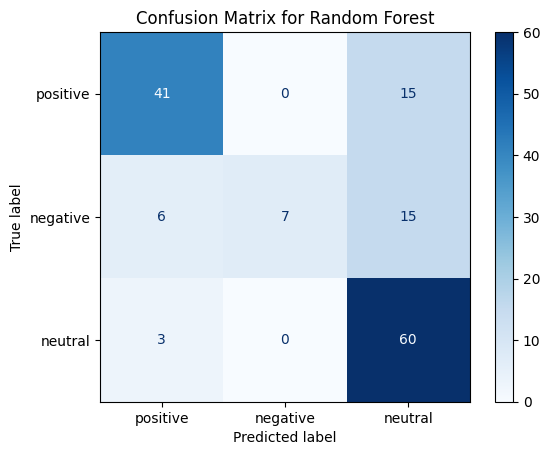

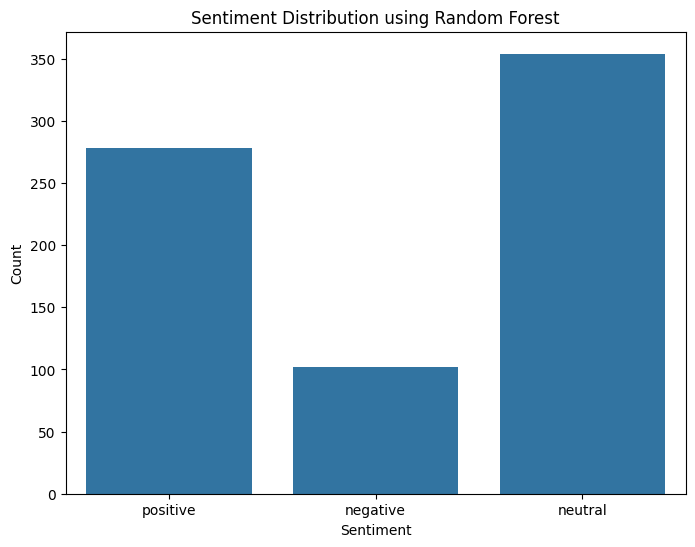

In [8]:
# Visualize confusion matrix for the best model
y_pred = grid_search_rf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative', 'neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Additional Visualizations
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='textblob_sentiment', data=data, order=['positive', 'negative', 'neutral'])
plt.title('Sentiment Distribution using Random Forest')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

output_file_path = 'analyzed_tweets.csv'
data.to_csv(output_file_path, index=False)